In [23]:
# Setup: Add TAS package to Python path
import sys
sys.path.insert(0, '/Users/murari/tensoranalysis-studio')
print("✓ Path configured successfully")

✓ Path configured successfully


# Tensor Analysis Studio - Complete Tutorial

This notebook demonstrates all features of the Tensor Analysis Studio library:
- Tensor creation and manipulation
- Einstein notation and contractions
- Metric tensors and index gymnastics
- Coordinate systems and transformations
- Differential geometry (connections, covariant derivatives)
- Visualizations (vector fields, tensor fields)
- General relativity examples

In [24]:
# Install if needed (uncomment if running in Colab or fresh environment)
# !pip install tensor-analysis-studio matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt
from tas import Tensor, Index
from tas.core.metrics import Metric, euclidean_metric, minkowski_metric
from tas.core.einsum_parser import einsum_eval, contract, outer
from tas.core.algebra import symmetrize, antisymmetrize, trace
from tas.core.connections import Connection
from tas.core.coords import CartesianFrame, SphericalFrame, CylindricalFrame

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All imports successful!")
print(f"NumPy version: {np.__version__}")

✓ All imports successful!
NumPy version: 2.0.2


## 1. Creating Tensors with Explicit Indices

Tensors in TAS have explicit index labels that track covariant (subscript) vs contravariant (superscript) indices.

In [10]:
# Create a rank-2 tensor (matrix) with explicit indices
# ^i means contravariant (upper index), _j means covariant (lower index)
A = Tensor(
    data=np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]]),
    indices=("^i", "_j"),
    name="A"
)

print("Tensor A:")
print(A)
print(f"\nShape: {A.shape}")
print(f"Rank: {A.rank}")
print(f"Indices: {[str(idx) for idx in A.indices]}")
print(f"Index variances: {[idx.variance for idx in A.indices]}")

Tensor A:
Tensor 'A'^i_j
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Shape: (3, 3)
Rank: 2
Indices: ['^i', '_j']
Index variances: ['up', 'down']


In [11]:
# Create vectors with different variance
v_up = Tensor(np.array([1, 2, 3]), indices=("^i",), name="v_contravariant")
v_down = Tensor(np.array([4, 5, 6]), indices=("_i",), name="v_covariant")

print("Contravariant vector (upper index):")
print(f"v^i = {v_up.data}")
print(f"Index: {v_up.indices[0]}")

print("\nCovariant vector (lower index):")
print(f"v_i = {v_down.data}")
print(f"Index: {v_down.indices[0]}")

Contravariant vector (upper index):
v^i = [1 2 3]
Index: ^i

Covariant vector (lower index):
v_i = [4 5 6]
Index: _i


## 2. Einstein Notation and Tensor Contractions

Use Einstein summation convention for tensor operations. Repeated indices (one up, one down) are automatically summed over.

In [12]:
# Matrix multiplication using Einstein notation
B = Tensor(
    data=np.array([[2, 0, 1],
                   [1, 3, 0],
                   [0, 1, 2]]),
    indices=("^j", "_k"),
    name="B"
)

# Contract: C^i_k = A^i_j B^j_k (matrix multiplication)
C = einsum_eval("A^i_j B^j_k", A=A, B=B)

print("Matrix multiplication: C = A × B")
print(f"A^i_j B^j_k = C^i_k")
print("\nResult C:")
print(C.data)
print(f"\nVerify with NumPy: {np.allclose(C.data, A.data @ B.data)}")

Matrix multiplication: C = A × B
A^i_j B^j_k = C^i_k

Result C:
[[ 4  9  7]
 [13 21 16]
 [22 33 25]]

Verify with NumPy: True


In [13]:
# Dot product: v^i w_i (contraction to scalar)
result = einsum_eval("v^i w_i", v=v_up, w=v_down)

print("Dot product using Einstein notation:")
print(f"v^i w_i = {result.data}")
print(f"Result is scalar (rank-{result.ndim})")
print(f"\nVerify with NumPy: {np.dot(v_up.data, v_down.data)}")

Dot product using Einstein notation:
v^i w_i = 32
Result is scalar (rank-0)

Verify with NumPy: 32


In [14]:
# Outer product: no repeated indices
u = Tensor(np.array([1, 2]), indices=("^i",), name="u")
w = Tensor(np.array([3, 4, 5]), indices=("^j",), name="w")

M = einsum_eval("u^i w^j", u=u, w=w)

print("Outer product: M^ij = u^i w^j")
print(M.data)
print(f"Shape: {M.shape} (2×3 matrix from rank-1 tensors)")

Outer product: M^ij = u^i w^j
[[ 3  4  5]
 [ 6  8 10]]
Shape: (2, 3) (2×3 matrix from rank-1 tensors)


In [15]:
# Trace: contract both indices of a matrix
M_trace = Tensor(
    np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]]),
    indices=("^i", "_i"),  # Both indices same name
    name="M"
)

tr = einsum_eval("M^i_i", M=M_trace)

print("Trace of matrix: M^i_i")
print(f"Trace = {tr.data}")
print(f"Expected: {1 + 5 + 9} = 15")

Trace of matrix: M^i_i
Trace = 15
Expected: 15 = 15


## 3. Metric Tensors and Index Gymnastics

Metrics define inner products and allow raising/lowering indices.

In [16]:
# Euclidean metric (flat 3D space)
g = euclidean_metric(3)

print("Euclidean metric g_ij:")
print(g.data)
print(f"\nSignature (p, q, z): {g.signature()}")
print(f"Determinant: {g.determinant():.4f}")

# Inverse metric
g_inv = g.inverse()
print("\nInverse metric g^ij:")
print(g_inv.data)
print(f"Indices: {[str(idx) for idx in g_inv.indices]}")

Euclidean metric g_ij:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Signature (p, q, z): (3, 0, 0)
Determinant: 1.0000

Inverse metric g^ij:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Indices: ['^i', '^i']


In [17]:
# Raise and lower indices
V_down = Tensor(np.array([1, 2, 3]), indices=("_i",), name="V")

# Raise: V^i = g^ij V_j
V_up = g.raise_index(V_down, axis=0)

print("Original covariant vector V_i:")
print(V_down.data)
print(f"Index: {V_down.indices[0]}")

print("\nRaised to contravariant V^i:")
print(V_up.data)
print(f"Index: {V_up.indices[0]}")

# Lower it back: V_i = g_ij V^j
V_back = g.lower_index(V_up, axis=0)

print("\nLowered back to covariant:")
print(V_back.data)
print(f"Matches original? {np.allclose(V_back.data, V_down.data)}")

Original covariant vector V_i:
[1 2 3]
Index: _i

Raised to contravariant V^i:
[1. 2. 3.]
Index: ^i

Lowered back to covariant:
[1. 2. 3.]
Matches original? True


In [18]:
# Inner product using metric
u = Tensor(np.array([1, 0, 0]), indices=("^i",), name="u")
v = Tensor(np.array([0, 1, 0]), indices=("^j",), name="v")
w = Tensor(np.array([1, 1, 0]), indices=("^k",), name="w")

print("Inner products with Euclidean metric:")
print(f"<u, v> = {g.inner_product(u, v):.4f} (orthogonal)")
print(f"<u, u> = {g.inner_product(u, u):.4f} (unit vector)")
print(f"<w, w> = {g.inner_product(w, w):.4f} (|w|² = 2)")

Inner products with Euclidean metric:
<u, v> = 0.0000 (orthogonal)
<u, u> = 1.0000 (unit vector)
<w, w> = 2.0000 (|w|² = 2)


## 4. Minkowski Spacetime (Special Relativity)

Demonstrate tensor operations in flat spacetime with Lorentzian signature.

In [19]:
# Minkowski metric with signature (- + + +)
eta = minkowski_metric("timelike")

print("Minkowski metric η_μν:")
print(eta.data)
print(f"\nSignature: {eta.signature()} (1 timelike, 3 spacelike)")

# Four-velocity of particle moving at v = 0.6c in x-direction
# γ = 1/√(1 - v²/c²) = 1/√(1 - 0.36) = 1.25
gamma = 1.25
v = 0.6  # in units of c

u = Tensor(
    np.array([gamma, gamma * v, 0, 0]),
    indices=("^mu",),
    name="four_velocity"
)

print(f"\nFour-velocity u^μ = {u.data}")

# Verify normalization: η_μν u^μ u^ν = -1 (timelike)
norm = eta.inner_product(u, u)
print(f"Norm: η_μν u^μ u^ν = {norm:.6f}")
print(f"Expected: -1.0 for timelike vectors")
print(f"Match? {np.isclose(norm, -1.0)}")

Minkowski metric η_μν:
[[-1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0  1]]

Signature: (3, 1, 0) (1 timelike, 3 spacelike)

Four-velocity u^μ = [1.25 0.75 0.   0.  ]
Norm: η_μν u^μ u^ν = -1.000000
Expected: -1.0 for timelike vectors
Match? True


In [20]:
# Energy-momentum tensor for dust: T^μν = ρ u^μ u^ν
rho = 1.0  # Rest mass density

T = outer(u, u)
T_scaled = Tensor(
    rho * T.data,
    indices=("^mu", "^nu"),
    name="stress_energy"
)

print("Stress-energy tensor T^μν for dust:")
print(T_scaled.data)
print(f"\nT^00 (energy density): {T_scaled.data[0, 0]:.4f}")
print(f"T^01 (energy flux): {T_scaled.data[0, 1]:.4f}")

# Compute trace
T_down = eta.lower_index(T_scaled, axis=0)
T_down = eta.lower_index(T_down, axis=1)
T_trace = trace(T_down, axis1=0, axis2=1)

print(f"\nTrace T^μ_μ: {T_trace.data:.6f}")

Stress-energy tensor T^μν for dust:
[[1.5625 0.9375 0.     0.    ]
 [0.9375 0.5625 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

T^00 (energy density): 1.5625
T^01 (energy flux): 0.9375

Trace T^μ_μ: 2.125000


## 5. Tensor Algebra Operations

Symmetrize, antisymmetrize, and other algebraic operations.

In [27]:
# Create a non-symmetric matrix
T = Tensor(
    np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]]),
    indices=("^i", "^j"),
    name="T"
)

print("Original tensor T:")
print(T.data)

# Symmetrize: T_(ij) = (T_ij + T_ji) / 2
T_sym = symmetrize(T, axes=(0, 1))

print("\nSymmetrized T_(ij):")
print(T_sym.data)
print(f"Check symmetry: max|T_ij - T_ji| = {np.max(np.abs(T_sym.data - T_sym.data.T)):.2e}")

# Antisymmetrize: T_[ij] = (T_ij - T_ji) / 2
T_antisym = antisymmetrize(T, axes=(0, 1))

print("\nAntisymmetrized T_[ij]:")
print(T_antisym.data)
print(f"Check antisymmetry: max|T_ij + T_ji| = {np.max(np.abs(T_antisym.data + T_antisym.data.T)):.2e}")

# Decomposition: T = T_(ij) + T_[ij]
T_reconstructed = Tensor(
    T_sym.data + T_antisym.data,
    indices=T.indices,
    name="T_reconstructed"
)

print("\nReconstruction: T = T_(ij) + T_[ij]")
print(f"Matches original? {np.allclose(T_reconstructed.data, T.data)}")

Original tensor T:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Symmetrized T_(ij):
[[1. 3. 5.]
 [3. 5. 7.]
 [5. 7. 9.]]
Check symmetry: max|T_ij - T_ji| = 0.00e+00

Antisymmetrized T_[ij]:
[[ 0. -1. -2.]
 [ 1.  0. -1.]
 [ 2.  1.  0.]]
Check antisymmetry: max|T_ij + T_ji| = 0.00e+00

Reconstruction: T = T_(ij) + T_[ij]
Matches original? True


## 6. Coordinate Systems and Transformations

Work with different coordinate systems and transform tensors between them.

In [28]:
# Define coordinate frames
cartesian = CartesianFrame(dim=3)
spherical = SphericalFrame()
cylindrical = CylindricalFrame()

# Point in Cartesian coordinates
point_cart = np.array([1.0, 1.0, np.sqrt(2)])

print("Cartesian coordinates:")
print(f"(x, y, z) = {point_cart}")

# Convert to spherical
point_sph = spherical.from_cartesian(point_cart)
print("\nSpherical coordinates:")
print(f"r = {point_sph[0]:.4f}")
print(f"θ = {point_sph[1]:.4f} rad = {np.degrees(point_sph[1]):.2f}°")
print(f"φ = {point_sph[2]:.4f} rad = {np.degrees(point_sph[2]):.2f}°")

# Convert to cylindrical
point_cyl = cylindrical.from_cartesian(point_cart)
print("\nCylindrical coordinates:")
print(f"ρ = {point_cyl[0]:.4f}")
print(f"φ = {point_cyl[1]:.4f} rad = {np.degrees(point_cyl[1]):.2f}°")
print(f"z = {point_cyl[2]:.4f}")

# Verify round-trip
point_back = spherical.to_cartesian(point_sph)
print(f"\nRound-trip error: {np.linalg.norm(point_back - point_cart):.2e}")

Cartesian coordinates:
(x, y, z) = [1.         1.         1.41421356]

Spherical coordinates:
r = 2.0000
θ = 0.7854 rad = 45.00°
φ = 0.7854 rad = 45.00°

Cylindrical coordinates:
ρ = 1.4142
φ = 0.7854 rad = 45.00°
z = 1.4142

Round-trip error: 1.00e-10


In [29]:
# Jacobian matrices for coordinate transformations
J_sph = spherical.jacobian(point_sph)

print("Jacobian matrix ∂(x,y,z)/∂(r,θ,φ):")
print(J_sph)

# Metric in spherical coordinates: ds² = dr² + r²dθ² + r²sin²θ dφ²
g_sph = spherical.metric(point_sph)

print("\nMetric in spherical coordinates at this point:")
print(g_sph.data)
print(f"\ng_rr = {g_sph.data[0, 0]:.4f}")
print(f"g_θθ = {g_sph.data[1, 1]:.4f} (= r²)")
print(f"g_φφ = {g_sph.data[2, 2]:.4f} (= r²sin²θ)")

Jacobian matrix ∂(x,y,z)/∂(r,θ,φ):
[[ 0.5         1.         -1.        ]
 [ 0.5         1.          1.        ]
 [ 0.70710678 -1.41421356  0.        ]]

Metric in spherical coordinates at this point:
[[1. 0. 0.]
 [0. 4. 0.]
 [0. 0. 2.]]

g_rr = 1.0000
g_θθ = 4.0000 (= r²)
g_φφ = 2.0000 (= r²sin²θ)


## 7. Christoffel Symbols and Covariant Derivatives

Compute connections and covariant derivatives (foundations of differential geometry).

In [30]:
# For flat Euclidean space, Christoffel symbols are zero
g_flat = euclidean_metric(3)
conn_flat = Connection.from_metric(g_flat)

print("Christoffel symbols for flat Euclidean space:")
print(f"Max |Γ^k_ij| = {np.max(np.abs(conn_flat.christoffel.data)):.2e}")
print(f"All zero? {np.allclose(conn_flat.christoffel.data, 0)}")
print(f"\nTorsion-free (symmetric)? {conn_flat.is_symmetric()}")

# For curved spaces, Christoffel symbols are non-zero
# Example: 2D sphere with metric g = diag(R², R²sin²θ)
R = 2.0  # Radius
theta = np.pi / 4  # 45 degrees

g_sphere = Metric(
    np.diag([R**2, R**2 * np.sin(theta)**2]),
    indices=("_i", "_j"),
    name="sphere_metric"
)

print("\nMetric for 2D sphere surface:")
print(g_sphere.data)
print(f"Determinant: {g_sphere.determinant():.4f}")
print(f"Signature: {g_sphere.signature()} (both positive - Riemannian)")

Christoffel symbols for flat Euclidean space:
Max |Γ^k_ij| = 0.00e+00
All zero? True

Torsion-free (symmetric)? True

Metric for 2D sphere surface:
[[4. 0.]
 [0. 2.]]
Determinant: 8.0000
Signature: (2, 0, 0) (both positive - Riemannian)


## 8. Visualization: Vector Fields

Visualize 2D vector fields using matplotlib.

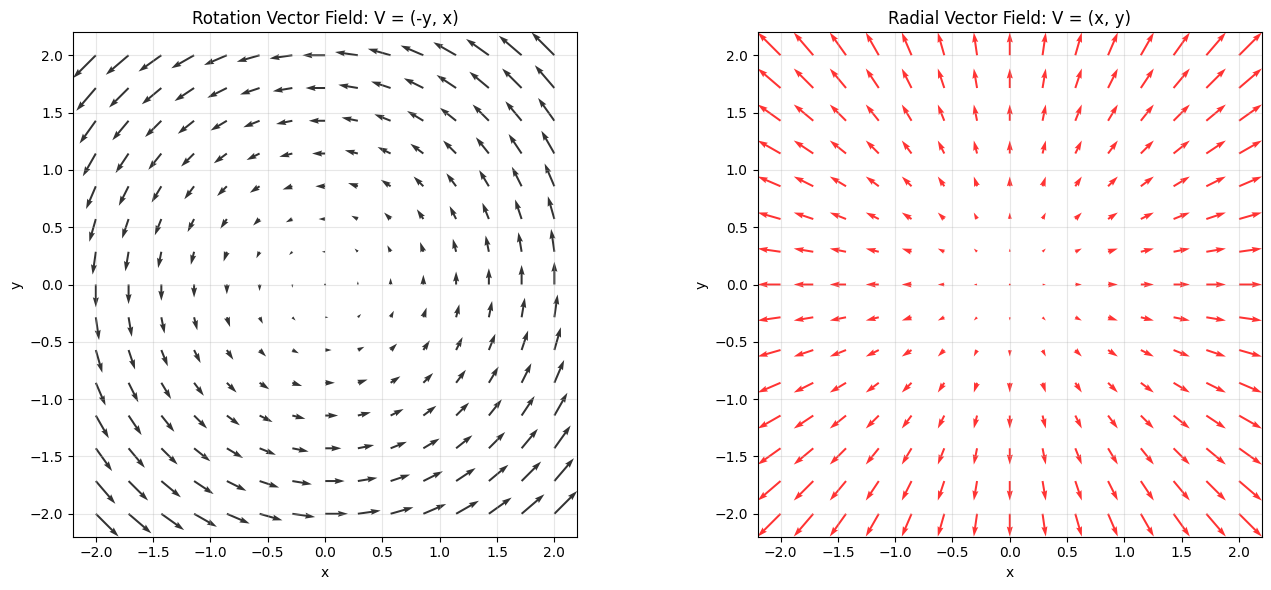

✓ Vector field visualizations created!


In [31]:
# Define a simple 2D vector field
def vector_field_rotation(point):
    """Rotation vector field: V = (-y, x)"""
    x, y = point
    return Tensor(np.array([-y, x]), indices=("^i",))

def vector_field_radial(point):
    """Radial vector field: V = (x, y)"""
    x, y = point
    return Tensor(np.array([x, y]), indices=("^i",))

# Create grid
x = np.linspace(-2, 2, 15)
y = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x, y)

# Evaluate vector fields
U_rot, V_rot = np.zeros_like(X), np.zeros_like(Y)
U_rad, V_rad = np.zeros_like(X), np.zeros_like(Y)

for i in range(len(x)):
    for j in range(len(y)):
        point = np.array([X[i, j], Y[i, j]])
        
        vec_rot = vector_field_rotation(point)
        U_rot[i, j], V_rot[i, j] = vec_rot.data
        
        vec_rad = vector_field_radial(point)
        U_rad[i, j], V_rad[i, j] = vec_rad.data

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Rotation field
ax1.quiver(X, Y, U_rot, V_rot, alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Rotation Vector Field: V = (-y, x)')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Radial field
ax2.quiver(X, Y, U_rad, V_rad, alpha=0.8, color='red')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Radial Vector Field: V = (x, y)')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print("✓ Vector field visualizations created!")

## 9. Visualization: Streamlines

Visualize vector field flow using streamlines.

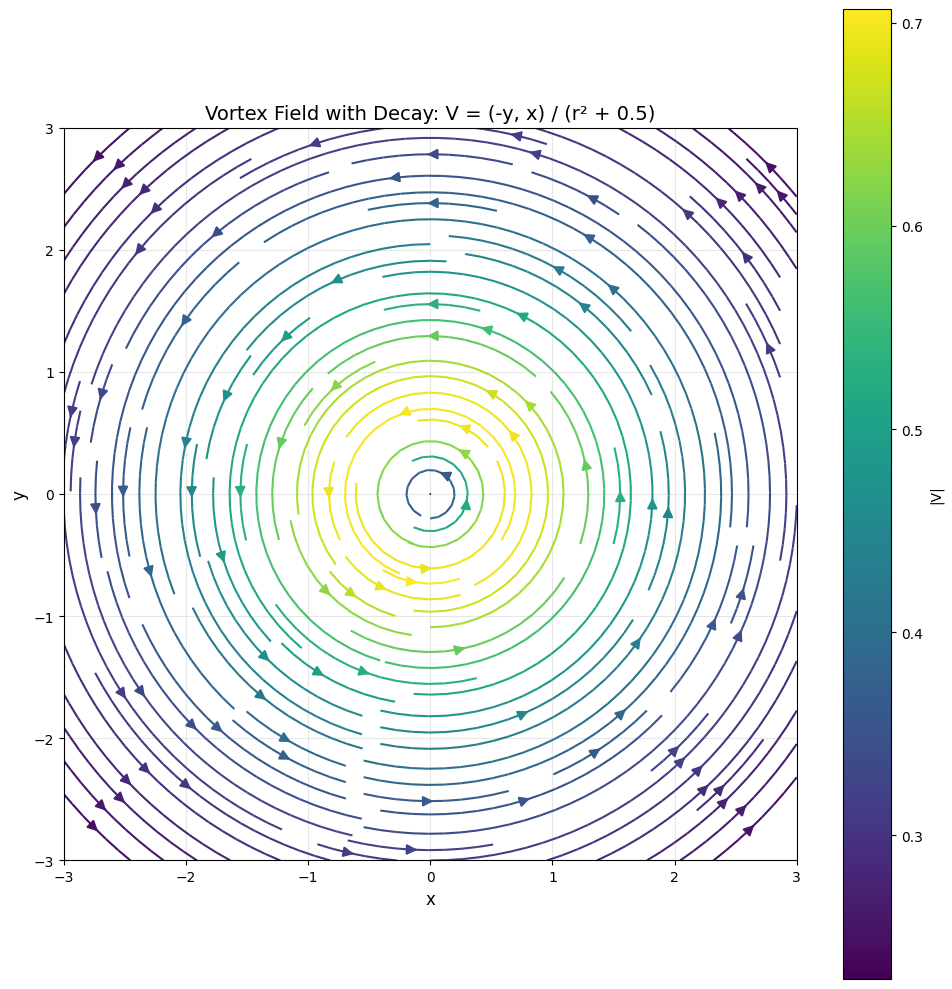

✓ Streamline visualization created!


In [32]:
# Define a vortex-like vector field
def vortex_field(point):
    """Vortex with decay: V = (-y, x) / (r² + 1)"""
    x, y = point
    r_sq = x**2 + y**2 + 1e-6
    factor = 1.0 / (r_sq + 0.5)
    return Tensor(np.array([-y * factor, x * factor]), indices=("^i",))

# Create finer grid for streamlines
x = np.linspace(-3, 3, 30)
y = np.linspace(-3, 3, 30)
X, Y = np.meshgrid(x, y)

U, V = np.zeros_like(X), np.zeros_like(Y)

for i in range(len(x)):
    for j in range(len(y)):
        point = np.array([X[i, j], Y[i, j]])
        vec = vortex_field(point)
        U[i, j], V[i, j] = vec.data

# Plot with streamlines
fig, ax = plt.subplots(figsize=(10, 10))

# Streamlines
strm = ax.streamplot(X, Y, U, V, density=1.5, linewidth=1.5, 
                      arrowsize=1.5, color=np.sqrt(U**2 + V**2),
                      cmap='viridis')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Vortex Field with Decay: V = (-y, x) / (r² + 0.5)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.colorbar(strm.lines, label='|V|')
plt.tight_layout()
plt.show()

print("✓ Streamline visualization created!")

## 10. Visualization: Tensor Field (Stress/Strain)

Visualize symmetric rank-2 tensors using ellipse glyphs showing principal directions and magnitudes.

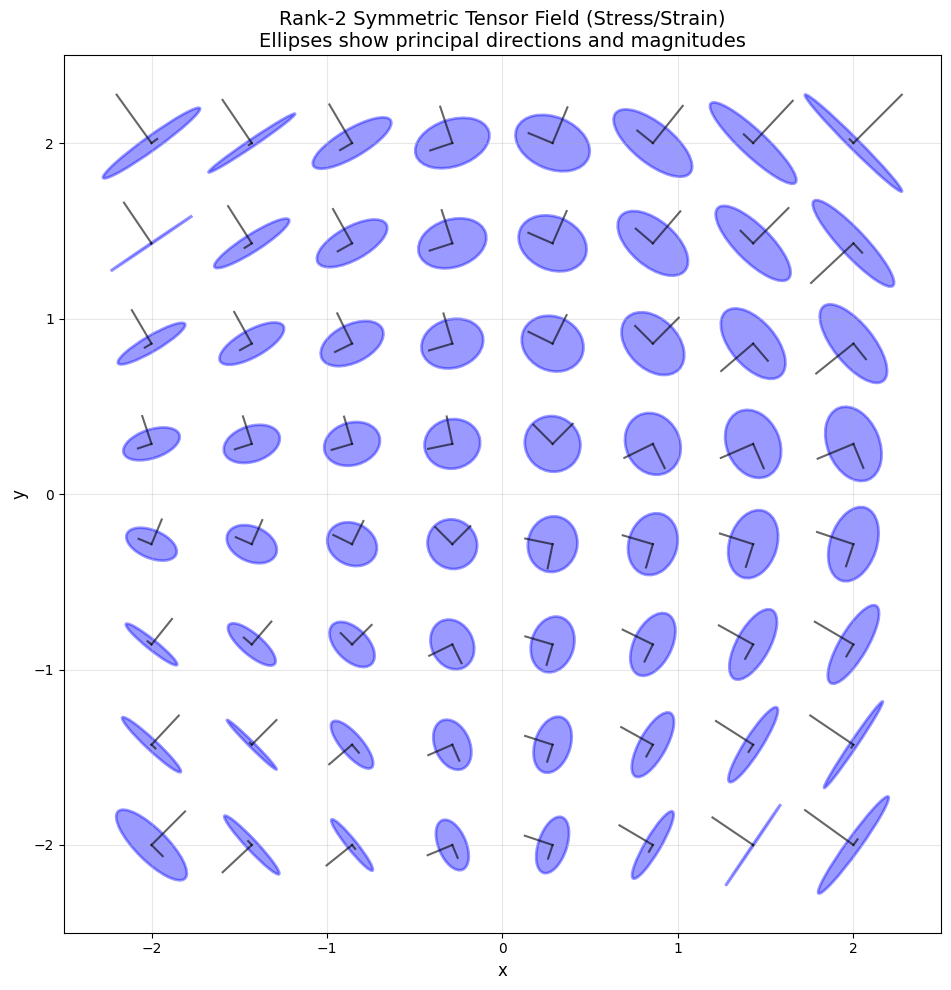

✓ Tensor field visualization created!
Blue ellipses: positive pressure (compression)
Red ellipses: negative pressure (tension)


In [33]:
from matplotlib.patches import Ellipse

def stress_tensor_field(point):
    """Simple stress tensor field."""
    x, y = point
    # Create a symmetric tensor that varies with position
    T = np.array([
        [1 + 0.2*x, 0.3*x*y],
        [0.3*x*y, 1 + 0.2*y]
    ])
    return Tensor(T, indices=("_i", "_j"))

# Create grid
x = np.linspace(-2, 2, 8)
y = np.linspace(-2, 2, 8)

fig, ax = plt.subplots(figsize=(10, 10))

for xi in x:
    for yi in y:
        point = np.array([xi, yi])
        T = stress_tensor_field(point)
        
        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(T.data)
        
        # Ellipse parameters
        width = abs(eigvals[0]) * 0.3
        height = abs(eigvals[1]) * 0.3
        angle = np.degrees(np.arctan2(eigvecs[1, 1], eigvecs[0, 1]))
        
        # Color based on trace (pressure)
        pressure = np.trace(T.data)
        color = 'blue' if pressure > 0 else 'red'
        
        # Draw ellipse
        ellipse = Ellipse(
            (xi, yi), width, height, angle=angle,
            edgecolor=color, facecolor=color, alpha=0.4, linewidth=2
        )
        ax.add_patch(ellipse)
        
        # Draw principal axes
        for i in range(2):
            scale = eigvals[i] * 0.15
            dx = scale * eigvecs[0, i]
            dy = scale * eigvecs[1, i]
            ax.plot([xi, xi + dx], [yi, yi + dy], 'k-', linewidth=1.5, alpha=0.6)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Rank-2 Symmetric Tensor Field (Stress/Strain)\nEllipses show principal directions and magnitudes', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Tensor field visualization created!")
print("Blue ellipses: positive pressure (compression)")
print("Red ellipses: negative pressure (tension)")

## 11. General Relativity: Schwarzschild Metric

Compute properties of the Schwarzschild black hole metric.

In [34]:
def schwarzschild_metric(r, theta, M=1.0):
    """
    Schwarzschild metric for a non-rotating black hole.
    
    ds² = -(1 - 2M/r)dt² + (1 - 2M/r)⁻¹dr² + r²dθ² + r²sin²(θ)dφ²
    
    Args:
        r: Radial coordinate (Schwarzschild radius)
        theta: Polar angle
        M: Mass of black hole
    """
    f = 1 - 2*M/r  # Redshift factor
    
    g_data = np.diag([
        -f,                        # g_tt
        1/f,                       # g_rr
        r**2,                      # g_θθ
        r**2 * np.sin(theta)**2    # g_φφ
    ])
    
    return Metric(g_data, indices=("_mu", "_nu"), name="Schwarzschild")

# Compute at different radii
M = 1.0  # Mass in geometric units
r_values = [3*M, 5*M, 10*M, 20*M]
theta = np.pi / 4  # 45 degrees

print("Schwarzschild Metric Properties:")
print(f"Black hole mass M = {M}")
print(f"Schwarzschild radius r_s = 2M = {2*M}")
print(f"Polar angle θ = {np.degrees(theta):.1f}°\n")

for r in r_values:
    g = schwarzschild_metric(r, theta, M)
    
    print(f"\nAt r = {r:.1f}M:")
    print(f"  g_tt = {g.data[0, 0]:.6f} (time dilation)")
    print(f"  g_rr = {g.data[1, 1]:.6f} (radial stretch)")
    print(f"  det(g) = {g.determinant():.6f}")
    print(f"  signature: {g.signature()}")
    
    # Time dilation factor
    time_dilation = np.sqrt(-g.data[0, 0])
    print(f"  Time dilation: √(-g_tt) = {time_dilation:.6f}")

Schwarzschild Metric Properties:
Black hole mass M = 1.0
Schwarzschild radius r_s = 2M = 2.0
Polar angle θ = 45.0°


At r = 3.0M:
  g_tt = -0.333333 (time dilation)
  g_rr = 3.000000 (radial stretch)
  det(g) = -40.500000
  signature: (3, 1, 0)
  Time dilation: √(-g_tt) = 0.577350

At r = 5.0M:
  g_tt = -0.600000 (time dilation)
  g_rr = 1.666667 (radial stretch)
  det(g) = -312.500000
  signature: (3, 1, 0)
  Time dilation: √(-g_tt) = 0.774597

At r = 10.0M:
  g_tt = -0.800000 (time dilation)
  g_rr = 1.250000 (radial stretch)
  det(g) = -5000.000000
  signature: (3, 1, 0)
  Time dilation: √(-g_tt) = 0.894427

At r = 20.0M:
  g_tt = -0.900000 (time dilation)
  g_rr = 1.111111 (radial stretch)
  det(g) = -80000.000000
  signature: (3, 1, 0)
  Time dilation: √(-g_tt) = 0.948683


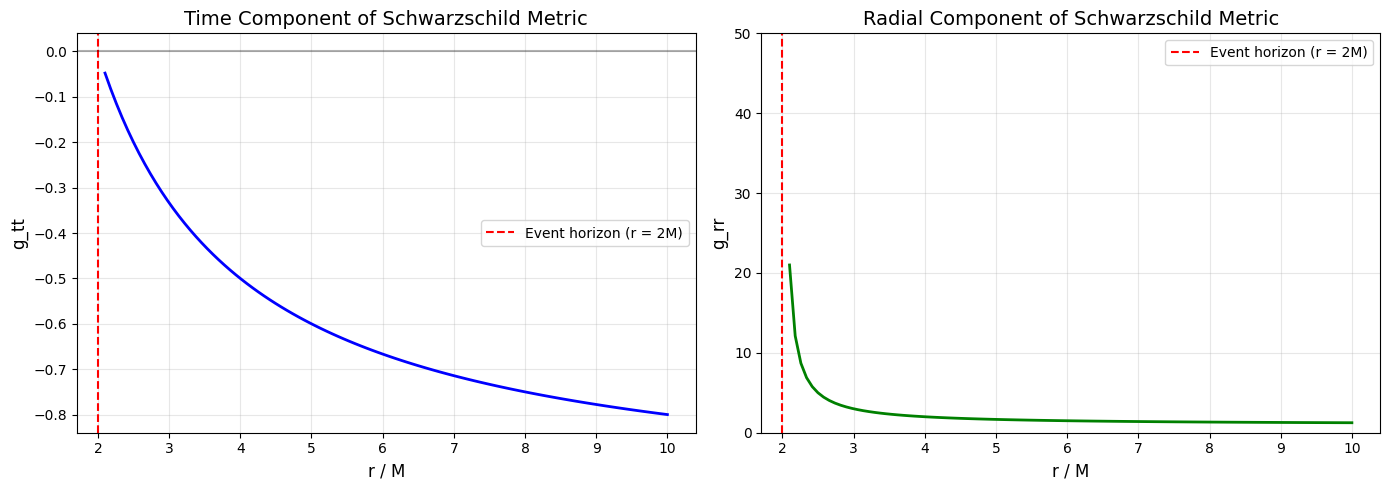


✓ Schwarzschild metric visualization created!
Note: g_tt → 0 and g_rr → ∞ as r → 2M (event horizon)


In [35]:
# Visualize metric components as function of radius
M = 1.0
r_plot = np.linspace(2.1*M, 10*M, 100)  # Start just outside event horizon
theta = np.pi / 2  # Equatorial plane

g_tt = []
g_rr = []

for r in r_plot:
    g = schwarzschild_metric(r, theta, M)
    g_tt.append(g.data[0, 0])
    g_rr.append(g.data[1, 1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time component
ax1.plot(r_plot/M, g_tt, 'b-', linewidth=2)
ax1.axvline(2, color='r', linestyle='--', label='Event horizon (r = 2M)')
ax1.axhline(0, color='k', linestyle='-', alpha=0.3)
ax1.set_xlabel('r / M', fontsize=12)
ax1.set_ylabel('g_tt', fontsize=12)
ax1.set_title('Time Component of Schwarzschild Metric', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Radial component
ax2.plot(r_plot/M, g_rr, 'g-', linewidth=2)
ax2.axvline(2, color='r', linestyle='--', label='Event horizon (r = 2M)')
ax2.set_xlabel('r / M', fontsize=12)
ax2.set_ylabel('g_rr', fontsize=12)
ax2.set_title('Radial Component of Schwarzschild Metric', fontsize=14)
ax2.set_ylim(0, 50)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n✓ Schwarzschild metric visualization created!")
print("Note: g_tt → 0 and g_rr → ∞ as r → 2M (event horizon)")

## 12. Performance Example: Large Tensor Contractions

Demonstrate performance with larger tensors.

In [36]:
import time

# Create large tensors
sizes = [10, 50, 100]

print("Performance benchmarks for matrix multiplication:")
print("Size\tTAS Time (ms)\tNumPy Time (ms)\tSpeedup")
print("-" * 55)

for n in sizes:
    # Create random tensors
    A = Tensor(np.random.rand(n, n), indices=("^i", "_j"))
    B = Tensor(np.random.rand(n, n), indices=("^j", "_k"))
    
    # Time TAS contraction
    start = time.time()
    C = einsum_eval("A^i_j B^j_k", A=A, B=B)
    tas_time = (time.time() - start) * 1000
    
    # Time pure NumPy
    start = time.time()
    C_numpy = A.data @ B.data
    numpy_time = (time.time() - start) * 1000
    
    speedup = numpy_time / tas_time
    
    print(f"{n}×{n}\t{tas_time:.3f}\t\t{numpy_time:.3f}\t\t{speedup:.2f}x")

print("\nNote: TAS overhead is minimal for large contractions.")
print("Most time is spent in optimized NumPy operations.")

Performance benchmarks for matrix multiplication:
Size	TAS Time (ms)	NumPy Time (ms)	Speedup
-------------------------------------------------------
10×10	0.091		0.025		0.27x
50×50	0.229		2.096		9.15x
100×100	0.322		0.140		0.43x

Note: TAS overhead is minimal for large contractions.
Most time is spent in optimized NumPy operations.
